<a href="https://colab.research.google.com/github/aruna09/Credit-Card-Risk-Default-Prediction/blob/main/Credit_Risk_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connecting to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the necessary libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
import numpy as np
from sklearn import tree
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

In [ ]:
path = "/content/drive/My Drive/Credit-Risk-Challenge/dataset"
os.chdir(path)

### Loading data

In [ ]:
train = pd.read_csv('train.csv',error_bad_lines=False)
test = pd.read_csv('test.csv',error_bad_lines=False)
submission = pd.read_csv('sample_submission.csv',error_bad_lines=False)

data = train

In [ ]:
data.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


### Visualization

In [ ]:
plot = sns.histplot(data=data, x='occupation_type', hue='gender', multiple='stack')
sns.set(rc = {'figure.figsize':(8,8)})
x_ticks = plot.get_xticklabels()
plt.setp(x_ticks, rotation=90)

In [ ]:
plot = sns.barplot(data=data, x='occupation_type', y='credit_card_default', hue='gender')
sns.set(rc = {'figure.figsize':(15,15)})
x_ticks = plot.get_xticklabels()
plt.setp(x_ticks, rotation=90)

In [ ]:
plot = sns.barplot(data=data, x='migrant_worker', y='default_in_last_6months')
sns.set(rc = {'figure.figsize':(15,8)})
x_ticks = plot.get_xticklabels()

### Dropping insignificant columns

In [ ]:
def drop_insignificant_columns(data):
  data = data.drop(['customer_id', 'name'], axis=1)
  return data

### Imputing Total Family Members

In [ ]:
def impute_total_family_members(data):
  data['total_family_members'] = data['total_family_members'].fillna(data.groupby(['migrant_worker'])['total_family_members'].transform('median'))
  return data

In [ ]:
def drop_null_total_family_member_rows(data):
  data = data.dropna(subset=['total_family_members'])
  return data

### Imputing Number of children:

Assumption: there are atleast both the parents. Hence when the Family only contains 2 or less than 2 members the number of children is 0


if the total Number Of Family Members <=2 then number of children = 0

if the total Number Of Family Members ==3 then number of children = 1

if the total Number Of Family Members ==4 then number of children = 2

if the total Number Of Family Members >=5 then number of children = 3

In [ ]:
def impute_no_of_children(data):
  data.loc[data['total_family_members'] <= 2, 'no_of_children'] = data.loc[data['total_family_members'] <= 2, 'no_of_children'].fillna(0)
  data.loc[data['total_family_members'] == 3, 'no_of_children'] = data.loc[data['total_family_members'] == 3, 'no_of_children'].fillna(1)
  data.loc[data['total_family_members'] == 4, 'no_of_children'] = data.loc[data['total_family_members'] == 4, 'no_of_children'].fillna(2)
  data.loc[data['total_family_members'] >= 5, 'no_of_children'] = data.loc[data['total_family_members'] >= 5, 'no_of_children'].fillna(3)
  return data

### Imputing Number of days Employed

Replacing all null values by the mean, given data is grouped by occupation and gender.

In [ ]:
def impute_no_of_days_employed(data):
  data['no_of_days_employed'] = data['no_of_days_employed'].fillna(data.groupby(['gender', 'occupation_type'])['no_of_days_employed'].transform('mean'))
  return data

### Imputing Yearly Debt Payments and Credit Score

Using Occupation type to group data and replace all null values by the mean of yearly debt payments for that occupation type.

In [ ]:
def impute_yearlyDebtPayments_and_CreditScore(data):
  data['yearly_debt_payments'] = data['yearly_debt_payments'].fillna(data.groupby(['gender', 'occupation_type'])['yearly_debt_payments'].transform('mean'))
  data['credit_score'] = data['credit_score'].fillna(data.groupby(['occupation_type', 'gender'])['credit_score'].transform('mean'))
  return data

### Imputing Migrant Worker

Deciding if a given entry is a migrant worker or not based on whether they have defaulted in the last 6 months. 

From data visualization, it is clear that a migrant worker tends to default more than everyone else.

In [ ]:
def impute_migrant_worker(data):
  data.loc[data['default_in_last_6months'] == 1, 'migrant_worker'] = data.loc[data['default_in_last_6months'] == 1, 'migrant_worker'].fillna(1)
  data.loc[data['default_in_last_6months'] == 0, 'migrant_worker'] = data.loc[data['default_in_last_6months'] == 0, 'migrant_worker'].fillna(0)
  return data

### Imputing all categorical values to ints using Label Encoder.

In [ ]:
def impute_categorical_variables(data):
  le.fit(data.owns_house)
  data.owns_house = le.transform(data.owns_house)

  le.fit(data.owns_car)
  data.owns_car = le.transform(data.owns_car)

  le.fit(data.gender)
  data.gender = le.transform(data.gender)

  le.fit(data.occupation_type)
  data.occupation_type = le.transform(data.occupation_type)
  return data

### Chopping off the decimal part.

In [ ]:
def make_int(data):
  return data.astype(int)

### Standardizing data

In [ ]:
from sklearn.preprocessing import RobustScaler
def standardize_data(data):
  scaler = preprocessing.StandardScaler().fit(data)
  #scaler = RobustScaler().fit(data)
  X_scaled = scaler.transform(data)
  return X_scaled

### Normalizing data

In [ ]:
def normalize_data(data):
  X_normalized = preprocessing.normalize(data, norm='l2')
  return X_normalized

### Dealing with the Class Imbalance

In [ ]:
pip install imbalanced-learn

In [ ]:
def smote_resampling_training_data():
  smote = SMOTE(sampling_strategy = 'minority')
  X_sm, y_sm = smote.fit_resample(x, y)
  return X_sm, y_sm

### Preprocessing the Train set

In [ ]:
data = drop_insignificant_columns(data)
data = drop_null_total_family_member_rows(data)
data = impute_migrant_worker(data)
data = impute_yearlyDebtPayments_and_CreditScore(data)
data = impute_no_of_days_employed(data)
data = impute_no_of_children(data)
data = impute_categorical_variables(data)
data.iloc[:, 0:16] = standardize_data(data.iloc[:, 0:16])
data.iloc[:, 0:16] = normalize_data(data.iloc[:, 0:16])

### Preprocessing the test dataset

In [ ]:
test = impute_total_family_members(test)
test = impute_migrant_worker(test)
test = impute_yearlyDebtPayments_and_CreditScore(test)
test = impute_no_of_days_employed(test)
test = impute_no_of_children(test)
test = impute_categorical_variables(test)
test.iloc[:, 2:] = standardize_data(test.iloc[:, 2:])
test.iloc[:, 2:] = normalize_data(test.iloc[:, 2:])

### Model Building

In [ ]:
x = data.iloc[:, 0: 16]
y = data.iloc[:, -1]

X_train, y_train = smote_resampling_training_data()

X_test = test.iloc[:, 2:]

### Logistic Regression = 92.03198/ SMOTE LR: 86.87

Regressive Feature Elimination

In [ ]:
#Selecting the Best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 6, step = 1)
clf = rfe_selector.fit(X_train, y_train)
clf.score(X_train, y_train)
X_train.columns[rfe_selector.get_support()]

Feature Importance

In [ ]:
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# display the relative importance of each attribute
print(model.feature_importances_)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train)
y_test = clf.predict(X_test)

### Naiive Bayes = 90.3807 / SMOTE: 90.27

In [ ]:
gnb = GaussianNB()
y_test = gnb.fit(X_train, y_train).predict(X_test)

KNN = 90.25124 / SMOTE: 87.0130

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)
y_test = neigh.predict(X_test)

Decision Trees = 80.40964 / SMOTE-88.36

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_test = clf.predict(X_test)
#tree.plot_tree(clf)

Random Forest = 90.3807 / SMOTE: 87.74

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_test = clf.predict(X_test)

SVM = 91.69243 / SMOTE: 87.95

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_test = clf.predict(X_test)

XGBoost

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
y_test = xgb_cl.predict(X_test)

Stacking models

In [ ]:
def models_all():
    all_models = dict()
    all_models['KNNC']= KNeighborsClassifier(n_neighbors = len(np.unique(y_train)), weights = 'distance')
    all_models['SVC']= SVC(kernel = 'linear', class_weight = 'balanced', break_ties = True)
    all_models['RF']= RandomForestClassifier(n_estimators= 200, oob_score = True, class_weight = "balanced", random_state = 20, ccp_alpha = 0.15)
    all_models['GNB'] = GaussianNB()
    all_models['Stacking'] = create_stacking_models()
    return all_models

In [ ]:
def create_stacking_models():
    base_models = list()
    base_models.append(('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y_train)) , weights = 'distance')))
    base_models.append(('SVC', SVC(kernel = 'linear', class_weight = 'balanced', break_ties = True)))    
    base_models.append(('GNB', GaussianNB()))
    base_models.append(('RF', RandomForestClassifier(n_estimators= 200, oob_score = True, class_weight = "balanced", random_state = 20, ccp_alpha = 0.1)))
    ##Base estimators which will be stacked together
    meta_model = LogisticRegression()
    final_model = StackingClassifier(estimators = base_models, final_estimator = meta_model, cv = 5)
    return final_model

In [ ]:
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise')
    return scores

In [ ]:
model_results = list()
models = models_all()
names = list()

# Create a for loop that iterates over each name, model in models dictionary 
for name, model in models.items():
    scores = evaluate_model(model)
    model_results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f) \n' % (name, np.mean(scores), np.std(scores)))

In [ ]:
base_models = list()
base_models.append(('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y_train)) , weights = 'distance')))
base_models.append(('SVC', SVC(kernel = 'linear', class_weight = 'balanced', break_ties = True)))    
base_models.append(('GNB', GaussianNB()))
base_models.append(('RF', RandomForestClassifier(n_estimators= 200, oob_score = True, class_weight = "balanced", random_state = 20, ccp_alpha = 0.1)))

##Base estimators which will be stacked together
meta_model = LogisticRegression()
final_model = StackingClassifier(estimators = base_models, final_estimator = meta_model, cv = 5)
final_model.fit(X_train, y_train)
y_test = final_model.predict(X_test)

### Plotting model performance

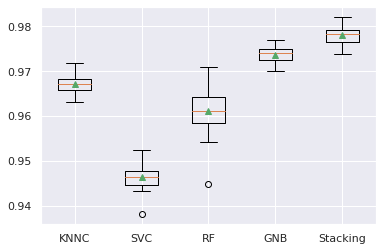

In [ ]:
# plot model performance for comparison
from matplotlib import pyplot
pyplot.boxplot(model_results, labels=names, showmeans=True)
pyplot.show()

### Create Submission csv

In [ ]:
submission_csv = pd.DataFrame({'customer_id':test.customer_id, 'credit_card_default': y_test})
submission_csv.to_csv(path + 'submission_file.csv', index=False)